In [1]:
# General library imports
#!pip install apyori 
from apyori import apriori 
import pandas as pd
import numpy as np
from functools import reduce
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from dateutil import relativedelta
import multiprocessing as mp
from itertools import combinations, groupby
from collections import Counter
from operator import itemgetter
import pickle
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances, pairwise_distances
from sklearn.decomposition import NMF
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES
from itertools import product 
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OneHotEncoder
import sys

# Graphing imports 
import matplotlib.pyplot as plt
import seaborn as sns

# Custom functions import 
sys.path.append('..') # Adding src directory to path 
from src.forecasting import *

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Graphing imports 
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_rows', 110)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2


In [2]:
recall_fn = lambda x, recc_col, actual_col: x[(~x[actual_col].isna())&(~x[recc_col].isna())].shape[0]/x[~x[actual_col].isna()].shape[0]
precision_fn = lambda x, recc_col, actual_col: x[(~x[actual_col].isna())&(~x[recc_col].isna())].shape[0]/x[~x[recc_col].isna()].shape[0]


def get_slope_func(x,y,order=1):
    #print(x)
    try:
        coeffs = np.polyfit(np.array(x), np.array(y), order)
        slope = coeffs[-1]
        return float(slope)
    except:
        return np.nan

def create_recency_vars(df,var_name, grouping_cols=None,date_col=None,lookback_period = 5):
    df = df.sort_values(grouping_cols + [date_col])
    for i in range(1,lookback_period+1):
        df[f'L{i}_{var_name}'] = df.groupby(grouping_cols)\
            [var_name].shift(i)
        
    df[f'L12_{var_name}'] = df.groupby(grouping_cols)\
        [var_name].shift(12)
    # Avg TDP
    add_cols = [f'L{i}_{var_name}' for i in  range(1,lookback_period+1)]
    tdps = df[add_cols].values
    df[f'avg_{var_name}'] =np.nansum(tdps,axis=1)/(lookback_period-np.sum(np.isnan(tdps),axis=1))
    return df

mode = lambda lst: Counter(lst).most_common()[0][0]

In [3]:
# Read in the data 
data = pd.read_csv('DATA/CA at Big Basket Data.csv')

In [4]:
# The timestamp is in the format of YYYY-MM-dd HH:MM:SS. 
# Convert it from string to datetime, and create a new field truncating it to a date level. 
# Get max date for each customer 
data['Created On'] = pd.to_datetime(data['Created On'])
data['Date'] = data['Created On'].apply(lambda x: x.date())
data['max_date'] = data.groupby('Member')['Created On'].transform('max')

In [5]:
# We will take the latest transaction by the consumer as a test case and see how well we are able to predict for either
data['test'] = data['max_date']==data['Created On']
data['test'].value_counts()

False    61261
True       880
Name: test, dtype: int64

In [6]:
print(f'Unique customers in data : {data["Member"].nunique()}')

Unique customers in data : 106


### Let's extract 3 features 
    1) Time between purchases
    2) No of products in basket 
    3) No. of products in basket that were in last basket 3 baskets
    4) If most common sku (up to that point) was present in the last order 

In [7]:
order_stat_lst = []
for idx, grp in data.groupby('Member'):
    
    # Time to last purchase and skus per basket
    grp_smry = grp.groupby(['Member','Created On','Date'])['SKU'].nunique().reset_index(drop=False)
    grp_smry = grp_smry.sort_values(by = ['Created On'])
    grp_smry['prev_date'] = grp_smry['Date'].shift(1)
    grp_smry.loc[~grp_smry['prev_date'].isna(),'time_last_purchase']  = grp_smry[~grp_smry['prev_date'].isna()].apply(lambda x: (x['Date'] - x['prev_date']).days,axis=1)

    # SKU coverage in prev 3 baskets 
    grp_smry_prods = grp.groupby(['Member','Created On','Date']).agg({'SKU':'unique','Description':'unique'}).reset_index(drop=False)
    grp_smry_prods = grp_smry_prods.sort_values(by = ['Created On'])
    
    
    # Combine the last n baskets into a single array
    
    # For SKUs
    combined_sku_baskets = []
    for rolling_grp in grp_smry_prods.groupby('Member')['SKU'].rolling(3,min_periods=1):
        combined_sku_baskets.append(list(set([x for row in rolling_grp for x in row])))
        
    # For Descrption 
    combined_category_baskets = []
    for rolling_grp in grp_smry_prods.groupby('Member')['Description'].rolling(3,min_periods=1):
        combined_category_baskets.append(list(set([x for row in rolling_grp for x in row])))
    
    # Add the series to the df
    grp_smry_prods['prev_order']  = pd.Series(combined_sku_baskets)
    grp_smry_prods['prev_order_cat'] = pd.Series(combined_category_baskets)
    
    # Count of SKUs in previou order 
    grp_smry_prods['last_order']  = grp_smry_prods['SKU'].shift(1)
    grp_smry_prods.loc[~grp_smry_prods['last_order'].isna(), 'no_skus_prev_order'] = grp_smry_prods.loc[~grp_smry_prods['last_order'].isna(),'last_order'].apply(lambda x: len(x))
    # grp_smry_prods['prev_order_cat']  = grp_smry_prods['Description'].shift(1)
    
    # Check the coverage of order with respect to the previous 3. 
    # **We then shift this series forward in order to avoid leakage**
    grp_smry_prods.loc[~grp_smry_prods['prev_order'].isna(),'in_prev_order_pcent'] = grp_smry_prods[~grp_smry_prods['prev_order'].isna()].apply(lambda x: sum([1 for _sku in x['SKU'] if _sku in x['prev_order']])/len(x['SKU']),axis=1)
    grp_smry_prods.loc[~grp_smry_prods['prev_order_cat'].isna(),'in_prev_order_cat_pcent'] = grp_smry_prods[~grp_smry_prods['prev_order_cat'].isna()].apply(lambda x: sum([1 for _sku in x['Description'] if _sku in x['prev_order_cat']])/len(x['Description']),axis=1)
    
    # We shfit this series, as the SKU of the current purchase would not be available prior to time of prediction 
    grp_smry_prods['in_prev_order_pcent'] = grp_smry_prods['in_prev_order_pcent'].shift(1)
    grp_smry_prods['prev_order_cat'] = grp_smry_prods['prev_order_cat'].shift(1)
   
    # We check if in the last order the most common sku purchased upto that point were present 
    # The hypothesis here is that if the user forgot to add their most common sku, they are more likely to make a quick, repeat purchase 
    sku_in_last_order = []
    for rolling_grp in grp_smry_prods.groupby('Member').rolling(grp_smry_prods.shape[0],min_periods=1):
        rolling_grp = rolling_grp.reset_index(drop=False)
        all_prior_orders = rolling_grp['prev_order'].tolist()
        last_order = all_prior_orders[-1]
        prior_orders = all_prior_orders[:-1]
        if len(prior_orders) == 0:
            sku_in_last_order.append(0)
        else:
            most_common_order = Counter([x for row in prior_orders for x in row]).most_common()[0][0]
            sku_in_last_order.append(1 if most_common_order in last_order else 0)
            
    # Append to the main df
    grp_smry_prods['most_common_sku_in_prev_order'] = sku_in_last_order

    # Combining 
    try:
        grp_smry_stats = grp_smry.merge(grp_smry_prods[['Member','Created On','Date','in_prev_order_pcent','in_prev_order_cat_pcent','no_skus_prev_order','most_common_sku_in_prev_order']], \
                                        on = ['Member','Created On','Date'], how='left')
    except:
        grp_smry_prods['Date'] = grp_smry_prods['Date'].apply(lambda x: x.date())
        grp_smry_stats = grp_smry.merge(grp_smry_prods[['Member','Created On','Date','in_prev_order_pcent','in_prev_order_cat_pcent','no_skus_prev_order','most_common_sku_in_prev_order']], \
                                        on = ['Member','Created On','Date'], how='left')
    
    # To use these values as features in a time series model, we will need to lag/create slope features, etc. 
    grp_smry_stats = create_recency_vars(grp_smry_stats.copy(deep=True),"SKU", grouping_cols=['Member'],date_col='Created On')
    grp_smry_stats = create_recency_vars(grp_smry_stats.copy(deep=True),"in_prev_order_pcent", grouping_cols=['Member'],date_col='Created On')
    grp_smry_stats = create_recency_vars(grp_smry_stats.copy(deep=True),"in_prev_order_cat_pcent", grouping_cols=['Member'],date_col='Created On')
    grp_smry_stats = create_recency_vars(grp_smry_stats.copy(deep=True),"time_last_purchase", grouping_cols=['Member'],date_col='Created On') 
    
    # Did the recent order contain fewer products than the running avg? 
    grp_smry_stats['small_prev_basket'] = grp_smry_stats['no_skus_prev_order'] < grp_smry_stats['avg_SKU']
    

    # Create slope feature 
    # Note: put this in a function
    grp_smry_stats.sort_values(by = ['Member','Created On'], inplace=True)
    grp_smry_stats['rn'] = grp_smry_stats.groupby('Member').cumcount() + 1
    grp_smry_stats.loc[~grp_smry_stats['L1_time_last_purchase'].isna(),'time_last_purchase_slope'] = grp_smry_stats[~grp_smry_stats['L1_time_last_purchase'].isna()]\
        .apply(lambda row: get_slope_func(\
        grp_smry_stats.loc[(grp_smry_stats['rn']>=row['rn'])&(grp_smry_stats['rn']<row['rn']+10),'L1_time_last_purchase'],\
        list(range(1,grp_smry_stats.loc[(grp_smry_stats['rn']>=row['rn'])&(grp_smry_stats['rn']<row['rn']+10),'L1_time_last_purchase'].shape[0]+1))\
                                             ),axis=1)
    
    # Create a running mode of customer time between orders 
    # We ensure no leakage 
    running_mode = []
    for rolling_grp in grp_smry_stats.groupby('Member')['time_last_purchase'].rolling(grp_smry_prods.shape[0],min_periods=1):
        if len(rolling_grp.tolist()[1:-1])>0:
            running_mode.append(mode(rolling_grp.tolist()[1:-1]))
        else:
            running_mode.append(np.nan)
            
    grp_smry_stats['time_between_orders_mode'] = running_mode 
    
    order_stat_lst.append(grp_smry_stats)
    
order_stat_df = pd.concat(order_stat_lst, axis=0)

assert data[['Member','Created On']].drop_duplicates().shape[0] == order_stat_df.shape[0], "Cust-Order combinations have been missed out"

In [8]:
order_stat_df = order_stat_df.merge(data[['Member','Created On','test']].drop_duplicates(), on = ['Member','Created On'],how='left')

In [9]:
# Remove obs with missing 'time_last_purchase'
order_stat_df = order_stat_df[~order_stat_df['time_last_purchase'].isna()]

In [10]:
# We divide the data into train and test. 
train = order_stat_df[order_stat_df['test']==False]
test = order_stat_df[order_stat_df['test']==True]
train.shape[0], test.shape[0]

(8175, 106)

In [11]:
# Outliers in features: 'time_between_orders_mode'
print(train['time_between_orders_mode'].describe())

np.quantile(train.loc[(~train['time_between_orders_mode'].isna()),'time_between_orders_mode'],q=[0.95,0.99,0.995])

count    8069.000000
mean        7.913248
std        12.609251
min         0.000000
25%         5.000000
50%         7.000000
75%         8.000000
max       426.000000
Name: time_between_orders_mode, dtype: float64


array([15., 31., 55.])

<AxesSubplot:xlabel='time_between_orders_mode', ylabel='Count'>

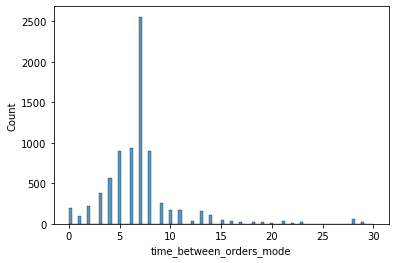

In [12]:
outlier_cap = 31 #99th percentile
sns.histplot(train[(~train['time_between_orders_mode'].isna())&(train['time_between_orders_mode']<outlier_cap)],x='time_between_orders_mode')

In [13]:
# We bin the customers according to their recent behavior
# For a majority of the time, we see that customers purchase with a recent mode around 7: Weekly customers
# For those who purchase at a mode of <2 -> forgetful/high velocity customers
def mode_bins(x):
    if x<3:
        return "high_velocity_cust"
    elif (x > 5) & (x < 9):
        return "weekly_cust"
    elif (x > 13) & ( x < 17):
        return "regular_cust"
    elif (x > 25) & ( x < 33):
        return "regular_cust"
    elif x >=33:
        return "outliers"
    else:
        return 'others'
        
train.loc[(~train['time_between_orders_mode'].isna()),'time_between_orders_mode_bins'] = \
    train.loc[(~train['time_between_orders_mode'].isna()),'time_between_orders_mode'].apply(mode_bins)

test.loc[(~test['time_between_orders_mode'].isna()),'time_between_orders_mode_bins'] = \
    test.loc[(~test['time_between_orders_mode'].isna()),'time_between_orders_mode'].apply(mode_bins)

print(train['time_between_orders_mode_bins'].value_counts(), test['time_between_orders_mode_bins'].value_counts())

weekly_cust           4382
others                2796
high_velocity_cust     518
regular_cust           295
outliers                78
Name: time_between_orders_mode_bins, dtype: int64 weekly_cust           62
others                33
regular_cust           8
high_velocity_cust     3
Name: time_between_orders_mode_bins, dtype: int64


In [14]:
### Capping obs in training 
# Outliers can significantly bias coef estimates/models 
# We use a simple technique to find outliers: Looking at observations in TRAIN we find the 99th percentile of globals obs and cap them 
# A more complex model at the customer/or a customer grouping level can and should be considered by students!
# Note: We only want to cap outliers in train. Since we are doing a grid search and further dividing the train dataset into train & val, we will only cap train outliers
# If we cap val outliers we might get an optimistic estimate of generalization error 
# With k-folds and k > 1, this becomes a more complex pipeline.
train['val_date'] = train.groupby('Member')['Created On'].transform('max')
val = train[train['val_date']==train['Created On']]
train = train[train['val_date']!=train['Created On']]



In [15]:
train.shape, val.shape, test.shape

((8069, 45), (106, 45), (106, 44))

In [16]:
# Outliers in features: 'time_between_orders_mode'
print(train['time_last_purchase'].describe())

np.quantile(train['time_last_purchase'],q=[0.95,0.99,0.995])

count    8069.000000
mean        9.260875
std        11.940284
min         0.000000
25%         5.000000
50%         7.000000
75%        10.000000
max       426.000000
Name: time_last_purchase, dtype: float64


array([24.  , 49.32, 63.66])

In [17]:
# We cap at 50. 
y_var_cap = 50

train['time_last_purchase'] = train['time_last_purchase'].apply(lambda x: min(x,y_var_cap))


In [18]:
# ###################################################
# xgb_sklearn_params = {'n_estimators': [5000],
#               'learning_rate' : [0.1],
#               'objective' : ["reg:squarederror"],
#               'eval_metric' : ['mae'],
#               'max_depth' : [1,3,5],
#               'subsample' : [1,0.8],
#               'colsample_bytree':[1],
#              'type':['xgb_sklearn'],
#              'transformations':['none','std'],
#              'missing_values' : ['none']}
# hyperparams_xgb_sklearn = create_hyperparam_object(xgb_sklearn_params)
# #######################################################
xgb_params = { 'booster' : ['dart','gbtree'],
              'num_boost_round': [5000],
              'eta' : [0.05,0.1],
              'objective' : ["reg:squarederror"],
              'eval_metric' : ['mae'],
              'max_depth' : [1,3,4,5],
              'subsample' : [1,0.8],
              'colsample_bytree':[1],
              'gamma' : [0,0.001],
             'type':['xgboost'],
             'transformations':['none','std'],
             'missing_values' : ['none']}


hyperparams_xgb = list(ParameterGrid(xgb_params))

en_params = {'l1_ratio': [0,0.25,0.5,0.75,1.0],
                     'alpha': list(np.logspace(-3,1,15)), #[0.01, 0.05,0.1,0.2],
                     'normalize' : [True,False],
                    'transformations':['none','std'],
                     'type':['elasticnet'],
            'missing_values' : ['fill0']}

hyperparams_en = list(ParameterGrid(en_params))
hyperparams_en = [x for x in hyperparams_en if (x['transformations'] != 'None')&(x['normalize']==True) == False]


plr_params = {'alpha': list(np.logspace(-3,1,15)),
                     'fit_intercept' : [True,False],
                      'transformations':['none','std'],
                     'type':['poisson'],
             'missing_values' : ['fill0']}
hyperparams_plr = list(ParameterGrid(plr_params))

# glr_params = {'alpha': list(np.logspace(-3,1,15)),
#                      'fit_intercept' : [True,False],
#                       'transformations':['none','std'],
#                      'type':['gamma'],
#              'missing_values' : ['fill0']}
# hyperparams_glr = list(ParameterGrid(glr_params))

# selected_xgb = np.random.choice(list(range(len(hyperparams_xgb))) , 5, replace=False)
#hyperparams_xgb_sklearn+ [x for idx, x in enumerate(hyperparams_xgb) if idx in selected_xgb]\
hyperparams = hyperparams_en + hyperparams_plr + hyperparams_xgb ##hyperparams_glr 

len(hyperparams)

338

In [19]:
# Encoding based on train categories
# Note: talk about hash encoding 
encoding = OneHotEncoder()
train['time_between_orders_mode_bins'] = train['time_between_orders_mode_bins'].fillna('missing')
encoding.fit(train[['time_between_orders_mode_bins']])
columns = encoding.get_feature_names().tolist()
print(columns)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)
train = pd.concat([train,pd.DataFrame(encoding.transform(train[['time_between_orders_mode_bins']]).todense(),columns = columns)],axis=1)
val = pd.concat([val,pd.DataFrame(encoding.transform(val[['time_between_orders_mode_bins']]).todense(),columns = columns)],axis=1)
test = pd.concat([test,pd.DataFrame(encoding.transform(test[['time_between_orders_mode_bins']]).todense(),columns = columns)],axis=1)

['x0_high_velocity_cust', 'x0_missing', 'x0_others', 'x0_outliers', 'x0_regular_cust', 'x0_weekly_cust']


In [20]:
train.loc[~train['small_prev_basket'].isna(),'small_prev_basket'] = train.loc[~train['small_prev_basket'].isna(),'small_prev_basket'].astype(int)
test.loc[~test['small_prev_basket'].isna(),'small_prev_basket'] = test.loc[~test['small_prev_basket'].isna(),'small_prev_basket'].astype(int)
val.loc[~val['small_prev_basket'].isna(),'small_prev_basket'] = val.loc[~val['small_prev_basket'].isna(),'small_prev_basket'].astype(int)

# train['small_prev_basket'] = train['small_prev_basket'].fillna(-1)
# test['small_prev_basket'] = test['small_prev_basket'].fillna(-1)
# val['small_prev_basket'] = val['small_prev_basket'].fillna(-1)

In [21]:
# Filling in missing
# train['most_common_sku_in_prev_order'] = train['most_common_sku_in_prev_order'].fillna(-1)
# test['most_common_sku_in_prev_order'] = test['most_common_sku_in_prev_order'].fillna(-1)
# val['most_common_sku_in_prev_order'] = val['most_common_sku_in_prev_order'].fillna(-1)

In [22]:
train['small_prev_basket'].value_counts()

1    4099
0    3970
Name: small_prev_basket, dtype: int64

In [23]:
y_var = 'time_last_purchase'
numeric_features = ['L1_in_prev_order_cat_pcent','L1_in_prev_order_pcent', 'L1_time_last_purchase', 'L2_in_prev_order_cat_pcent', 'L2_in_prev_order_pcent', 'L2_time_last_purchase', 
'L3_in_prev_order_cat_pcent', 'L3_in_prev_order_pcent', 'L3_time_last_purchase', 'avg_SKU', 'avg_in_prev_order_cat_pcent', 'avg_in_prev_order_pcent', 
'avg_time_last_purchase', 'time_between_orders_mode', 'time_last_purchase_slope']
non_numeric_features = ['small_prev_basket'] + columns

In [24]:
# We employ a simple strategy for filling in missing data - removing the obs. 
# Since all customers have fairly long histories, we don't expect this to bias out test error since all features there should be available
# However, in real world scenarios we will have new customers in these datasets, and for them many of the features we've created here would be missing
# We would need to either segment and build a seperate model for them, or use more complex missing feature strategies 
train.shape, val.shape, test.shape

((8069, 51), (106, 51), (106, 50))

In [25]:
grid_search_results = forecasting_grid_search(train = train[(train[numeric_features + non_numeric_features].isna().sum(axis=1)==0)],
                            val = val,
                            hyperparams = hyperparams,
                            y_var = y_var,
                            numeric_features = numeric_features,
                            categorical_features = non_numeric_features,
                            weights = None,
                            metrics = ['forecasting_score','mae','r2','rmse'])

Param 1 of 338
Param 11 of 338
Param 21 of 338
Param 31 of 338
Param 41 of 338
Param 51 of 338
Param 61 of 338
Param 71 of 338
Param 81 of 338
Param 91 of 338
Param 101 of 338
Param 111 of 338
Param 121 of 338
Param 131 of 338
Param 141 of 338
Param 151 of 338
Param 161 of 338
Param 171 of 338
Param 181 of 338
Param 191 of 338
Param 201 of 338
Param 211 of 338
Param 221 of 338
Param 231 of 338
Param 241 of 338
Param 251 of 338
Param 261 of 338
Param 271 of 338
Param 281 of 338
Param 291 of 338
Param 301 of 338
Param 311 of 338
Param 321 of 338
Param 331 of 338


In [26]:
sorted_res = rank_grid_search_results(results = grid_search_results, \
                                              rank_by_metric = 'rmse', greater_is_better = False, return_top=False)

In [27]:
error, best_params = rank_grid_search_results(results = grid_search_results, \
                                              rank_by_metric = 'rmse', greater_is_better = False)
best_params, error

({'booster': 'dart',
  'colsample_bytree': 1,
  'eta': 0.1,
  'eval_metric': 'mae',
  'gamma': 0,
  'max_depth': 3,
  'missing_values': 'none',
  'num_boost_round': 159,
  'objective': 'reg:squarederror',
  'subsample': 0.8,
  'transformations': 'none',
  'type': 'xgboost'},
 {'forecasting_score': 0.738993710691824,
  'mae': 4.23112553920386,
  'r2': 0.3696715420598169,
  'rmse': 6.726421621262841})

In [28]:
# Now that we've decided upon our hyperparameters, we will cap the validation data as well, and use both to create a model to predict next order date
final_train = train.append(val)
final_train['time_last_purchase'] = final_train['time_last_purchase'].apply(lambda x: min(x,y_var_cap))
final_model = final_model_obj(train = final_train[(final_train[numeric_features + non_numeric_features].isna().sum(axis=1)==0)],
                              test = test,
                              best_params = best_params,
                              y_var = y_var,
                              numeric_features =numeric_features,
                              categorical_features = non_numeric_features,
                              weights = None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

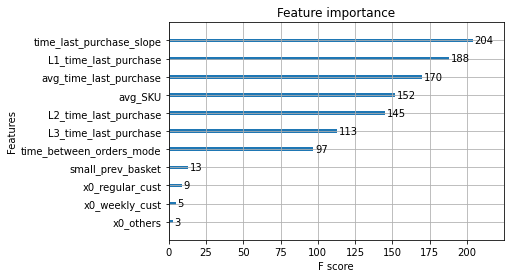

In [29]:
# Ways in which XGB measures feature importance
xgb.plot_importance(final_model)

In [30]:
#train[train['Member'].isin(test.loc[test['time_last_purchase']>30,'Member'].unique())].groupby('Member')['time_last_purchase'].median(),train[train['Member'].isin(test.loc[test['time_last_purchase']>30,'Member'].unique())].groupby('Member')['time_last_purchase'].mean()

In [31]:
# Test error is extremely high! But a majority of that comes from the outliers 
test_predictions = predict_and_score(final_model, final_train[final_train[numeric_features+ non_numeric_features].isna().sum(axis=1)==0], test,y_var, best_params, metrics = ['forecasting_score','mae','r2','rmse','forecasting_report'],\
    numeric_features = numeric_features, categorical_features = non_numeric_features,verbose = True)

Train forecasting_score : 0.7133341818336092
Train mae : 3.494508016939395
Train r2 : 0.44029840110609064
Train rmse : 5.615531027236797
Train forecasting_report :  2    0.353061
 1    0.335242
-1    0.179331
 0    0.132366
Name: time_last_purchase, dtype: float64
Test forecasting_score : 0.6823899371069183
Test mae : 7.223606878856443
Test r2 : -0.023740628129482744
Test rmse : 20.674162757517106
Test forecasting_report :  2    0.358491
 1    0.283019
-1    0.188679
 0    0.169811
Name: time_last_purchase, dtype: float64


In [32]:
# Let's compute error by buckets
test['predict'] = test_predictions

# Let's round off the prediction and bucket on the basic of time since last purchase and predict for each group
test['predict'] = test['predict'].round(0)

# Outliers vs all others
test['is_outlier'] = test['time_last_purchase'].apply(lambda x: x>y_var_cap)
test['cust_count'] = test.groupby('is_outlier')['Member'].transform('count')
display(test.groupby(['is_outlier','cust_count']).apply(lambda x: mean_squared_error(x['time_last_purchase'],x['predict'], squared=False)).reset_index(drop=False))


# Based on logical bins
test['time_last_purchase_bin'] = test['time_last_purchase'].apply(mode_bins)
test['cust_count'] = test.groupby('time_last_purchase_bin')['Member'].transform('count')
display(test.groupby(['time_last_purchase_bin','cust_count']).apply(lambda x: mean_squared_error(x['time_last_purchase'],x['predict'], squared=False)).reset_index(drop=False))

# Based on bins of 5 till 30 days
test['time_last_purchase_grps'] = test['time_last_purchase'].apply(lambda x: x//5)
test['time_last_purchase_grps'] = test['time_last_purchase_grps'].apply(lambda x: min(x,6))
test['cust_count'] = test.groupby('time_last_purchase_grps')['Member'].transform('count')

display(test.groupby(['time_last_purchase_grps','cust_count']).apply(lambda x: mean_squared_error(x['time_last_purchase'],x['predict'], squared=False)).reset_index(drop=False))


,is_outlier,cust_count,0
0,False,102,5.495988
1,True,4,102.970870


,time_last_purchase_bin,cust_count,0
0,high_velocity_cust,7,6.000000
1,others,44,6.388911
2,outliers,4,102.970870
3,regular_cust,11,8.174239
4,weekly_cust,40,2.729469


,time_last_purchase_grps,cust_count,0
0,0.0,14,4.636809
1,1.0,52,3.830545
2,2.0,21,4.561746
3,3.0,6,5.627314
4,4.0,3,13.441230
5,5.0,5,11.653326
6,6.0,5,92.283260


In [33]:
### Baseline: used the mode of the customer in train to predict the next order
if 'baseline_prediction' in test.columns:
    test=test.drop(columns = ['baseline_prediction'])
    
baseline = val[['Member','time_between_orders_mode']]
baseline.rename(columns = {'time_between_orders_mode':'baseline_prediction'},inplace=True)
test = test.merge(baseline, on = ['Member'],how='left')

display(test.groupby('test').apply(lambda x: mean_squared_error(x['time_last_purchase'],x['baseline_prediction'],squared=False)).reset_index(drop=False))

# Outliers vs all others
test['cust_count'] = test.groupby('is_outlier')['Member'].transform('count')
display(test.groupby(['is_outlier','cust_count']).apply(lambda x: mean_squared_error(x['time_last_purchase'],x['baseline_prediction'], squared=False)).reset_index(drop=False))


# Based on logical bins
test['cust_count'] = test.groupby('time_last_purchase_bin')['Member'].transform('count')
display(test.groupby(['time_last_purchase_bin','cust_count']).apply(lambda x: mean_squared_error(x['time_last_purchase'],x['baseline_prediction'], squared=False)).reset_index(drop=False))

# Based on bins of 5 till 30 days
test['cust_count'] = test.groupby('time_last_purchase_grps')['Member'].transform('count')

display(test.groupby(['time_last_purchase_grps','cust_count']).apply(lambda x: mean_squared_error(x['time_last_purchase'],x['baseline_prediction'], squared=False)).reset_index(drop=False))


,test,0
0,True,21.383515


,is_outlier,cust_count,0
0,False,102,7.014690
1,True,4,104.223318


,time_last_purchase_bin,cust_count,0
0,high_velocity_cust,7,12.340410
1,others,44,7.687061
2,outliers,4,104.223318
3,regular_cust,11,9.634219
4,weekly_cust,40,2.880972


,time_last_purchase_grps,cust_count,0
0,0.0,14,9.323549
1,1.0,52,4.582576
2,2.0,21,5.367450
3,3.0,6,6.855655
4,4.0,3,15.673757
5,5.0,5,14.676512
6,6.0,5,93.229824


In [34]:
# Error analysis <- Done
# Outliers <- Done (kinda)
# Adding features <- Done
# Forecasting/Customer segmentation <- to do. 
# Feature selection <- Implicit. 
# most frequent sku not in last order bool <- Added. Not useful. 
# cluster by mode of customer <- Segmentation. Not Done. 
